# Oil and Gas Production Forecasting - arima/sarima model

### 1-Imports and dataset loading

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import json

sns.set(style="whitegrid")

/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load dataset
df = pd.read_csv("../data/processed/oil_production_features.csv")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

In [4]:
# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

### 2-Stationarity Check
* ARIMA models require the input time series to be stationary.

* Since the oil production data exhibits both trend and seasonal patterns, we will apply SARIMA, which incorporates seasonal differencing to address these characteristics.

### 3. Bayesian Hyperparameter Tuning with Optuna

Best practices for tuning ARIMA models include:

- Optimizing the autoregressive parameters (p, d, q) that control the AR, differencing, and MA components.
- Tuning the seasonal parameters (P, D, Q, s) corresponding to the seasonal AR, differencing, MA, and seasonal period.
- For monthly data, set the seasonal period s = 12 to capture yearly seasonality.

**Terminology from statistical modeling:**

- AR(p): Autoregressive models of order p  
- MA(q): Moving average models of order q  
- ARMA(p, q): Combination of autoregressive and moving average models  
- ARIMA(p, d, q): Models that include integration (differencing) to achieve stationarity  
- SARIMA(P, D, Q, s): Seasonal ARIMA to handle seasonal effects  
- Regression models with errors following any of the above ARIMA-type structures


In [5]:
def objective(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    P = trial.suggest_int('P', 0, 2)
    D = trial.suggest_int('D', 0, 1)
    Q = trial.suggest_int('Q', 0, 2)
    s = 12  # fixed seasonality

    try:
        model = SARIMAX(train['MBBL/D'],
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False).fit(disp=False)

        pred = model.forecast(steps=len(test))
        return mean_absolute_error(test['MBBL/D'], pred)
    except:
        return np.inf  # handle failed model fits

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-09-17 16:15:47,189] A new study created in memory with name: no-name-051f3eae-b730-4c4c-ad9e-43a9dfafcefe
[I 2025-09-17 16:15:52,510] Trial 0 finished with value: 230.03363982894524 and parameters: {'p': 4, 'd': 1, 'q': 0, 'P': 0, 'D': 1, 'Q': 2}. Best is trial 0 with value: 230.03363982894524.
/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2025-09-17 16:15:55,539] Trial 1 finished with value: 262.5111500367045 and parameters: {'p': 2, 'd': 0, 'q': 5, 'P': 0, 'D': 0, 'Q': 1}. Best is trial 0 with value: 230.03363982894524.
[I 2025-09-17 16:15:56,788] Trial 2 finished with value: 2626.22971273342 and parameters: {'p': 0, 'd': 2, 'q': 0, 'P': 2, 'D': 0, 'Q': 2}. Best is trial 0 with value: 230.03363982894524.
[I 2025-09-17 16:16:00,834] Trial 3 finished with value: 327.

In [6]:
# Best params.
best_params = study.best_params
best_params

{'p': 5, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1}

In [ ]:
# Save the best parameters to a JSON file
with open('../models/arima_best_params.json', 'w') as f:
    json.dump(best_params, f)

### 4-Train final SARIMA model

In [8]:
model = SARIMAX(train['MBBL/D'],
                order=(best_params['p'], best_params['d'], best_params['q']),
                seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], 12),
                enforce_stationarity=False,
                enforce_invertibility=False).fit(disp=False)

pred = model.forecast(steps=len(test))

/home/indros0603/oil-production-analysis/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5-Standardized evaluation metrics

In [9]:
y_true = test['MBBL/D'].values
y_pred = pred.values

metrics = {
    "MAE": mean_absolute_error(y_true, y_pred),
    "MSE": mean_squared_error(y_true, y_pred),
    "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
    "R2": r2_score(y_true, y_pred),
    "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
}
print(metrics)

{'MAE': 194.80078905587789, 'MSE': 72705.75926343458, 'RMSE': np.float64(269.6400550056215), 'R2': -0.6829561039566443, 'MAPE': np.float64(9.91563421456072)}


In [10]:
# Save the model and the results.
results = {"model": "ARIMA", "metrics": metrics}
with open('../results/arima_results.json', 'w') as f:
    json.dump(results, f)

pd.DataFrame({"ds": test['period'], "y_true": y_true, "y_pred": y_pred}).to_csv(
    "../results/arima_predictions.csv", index=False
)

### 6-Plot predictions

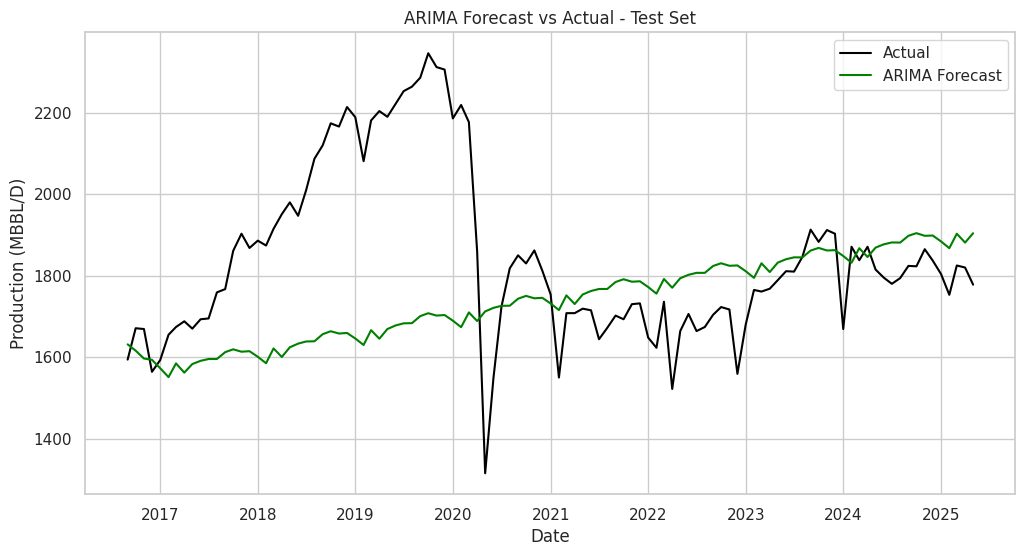

In [11]:
plt.figure(figsize=(12,6))
plt.plot(test['period'], y_true, label='Actual', color='black')
plt.plot(test['period'], y_pred, label='ARIMA Forecast', color='green')
plt.title("ARIMA Forecast vs Actual - Test Set")
plt.xlabel("Date")
plt.ylabel("Production (MBBL/D)")
plt.legend()
plt.show()

We applied SARIMA models and used Bayesian optimization to tune the hyperparameters (p, d, q)(P, D, Q, s). Given the strong yearly seasonality in oil production, the seasonal period was set to 12 months. Model evaluation was performed on a holdout test set representing 20% of the data, using the same metrics applied to the Prophet model to maintain consistency. All outputs, including performance metrics and predictions, were saved in a standardized format to enable centralized comparison in later analyses. 